# refellips demo: Solid/Air batch fitting
This example demonstrates the use of refellips for batch fitting multiple ellipsometry data files; multiple points across the same surface. This example uses single-wavelength multi-angle ellipsometry data acquired from an Accurion EP4 ellipsometer.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import copy
import pickle

from refnx.analysis import CurveFitter
from refnx.reflect import Linear, Erf
from scipy.interpolate import griddata
from matplotlib.patches import Rectangle,Circle
from scipy.optimize import curve_fit

def powerlaw(x, a, k):
    return a*x**k

def line(x, a, b):
    return a*x + b

### Import data

In [3]:
# Will need to add the repo directory to sys.path (system specific)
sys.path.append('../')

from dataSE import DataSE, open_EP4file
from reflect_modelSE import ReflectModelSE
from objectiveSE import ObjectiveSE
from structureSE import RI

### Build model

In [4]:
from refnx.reflect import Slab, SLD
si     = RI('../materials/silicon.csv')
sio2   = RI('../materials/silica.csv')
air    = RI('../materials/air.csv')

#Demo use of Cauchy parameters instead of using a .csv file for refractive indicies.
PNIPAM = RI(A=1.47, B=0.00495, C=0, name='PNIPAM')
PNIPAM.A.setp(vary=True, bounds=(1.46,1.5))
PNIPAM.B.setp(vary=True, bounds=(4000,6000))

PNIPAM_layer = PNIPAM(150, 0)
PNIPAM_layer.thick.setp(vary=True, bounds=(1,1000))
# PNIPAM_layer.rough.setp(vary=True, bounds=(50,300))

# PNIPAM_layer.interfaces = Erf()

struc = air() | PNIPAM_layer | si() #will subtract the SiO2 layer thickness later
model = ReflectModelSE(struc, wavelength=658)

### Load in maps (EP4 ellipsometry data files with x, y locations) in with Glob

In [5]:
mapnames = glob.glob("ExampleMaps//*.dat")

maps = {}
for name in mapnames:
    prettyname = ' '.join(os.path.basename(name).split('_')[:1])
    print(prettyname)
    maps[prettyname]  =  open_EP4file(name)

post synthesis.dat
No time data.
Treating as multiple locations
pre synthesis.dat
No time data.
Treating as multiple locations


C:\Users\c3238010\.conda\envs\ellips\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\c3238010\.conda\envs\ellips\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


### Fitting all data points

In [6]:
metaObjs = {}
outputs = {}
for name, lm in maps.items():
    Objs = []
    output = []
    for data in lm:
        obj = ObjectiveSE(copy.deepcopy(model), data)
        fitter = CurveFitter(obj)
#         fitter.fit('differential_evolution')
        fitter.fit('least_squares')
        print (obj.chisqr())
    
        loc_thick_data = [data.metadata['X pos'],
                          data.metadata['Y pos'],
                          obj.model.structure[1].thick.value,
                          obj.model.structure[1].rough.value,
                          obj.chisqr()]
        output.append(loc_thick_data)
        Objs.append(obj)
    
    metaObjs[name] = Objs
    outputs[name] = pd.DataFrame(data=output, columns=['X pos', 'Y pos', 'thickness', 'roughness', 'chisqr'])

0.015241667889131024
0.005486593768944693
0.004468784395068955
0.010151994979540573
0.0028174183141296497
0.006094397203665371
0.029931722221145884
0.0014308436407009341
0.0041018066459913745
0.004203041977847656
0.027275663755969348
0.0059541765338923126
0.00436060161695132
0.015566181256711168
0.0019790408375608575
0.0016320461847051243
0.003014588562503162
0.001862000617369242
0.003005342334010605
0.001321338316921339
0.0014462434296045057
0.0015136464982240104
0.002193420746430157
0.003074985868426995
0.0016398299618254463
0.005360167423952206
0.0022155157353647465
0.00547993011136442
0.0009310646147970595
0.005240574245366492
0.010958590815867787
0.08107624247093645
0.031333212063271096
0.023792420788140735
0.021625604123362768
0.02127816879956625
0.022669831146491508
0.031150194172847624
0.01984519640348436
0.023749944914414088
0.02698105901924128
0.03074242075718253
0.027164565689624384
0.02116914484407216
0.02242938514453382
0.028030760775016435
0.028476049125743266
0.024531931

## Pickle the output so you don't have to keep refitting

### Save fit

In [7]:
pickle.dump(outputs, open('EllipsOutput.pkl', 'wb'))

### Load fit

In [8]:
outputs = pickle.load(open('EllipsOutput.pkl', 'rb'))
for name, output in outputs.items():
    outputs[name] = output[output['chisqr']<5]
    outputs[name]['thickness'] = outputs[name]['thickness']/10

<ipython-input-8-1c6cbfce8ac2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputs[name]['thickness'] = outputs[name]['thickness']/10


# Plot the maps

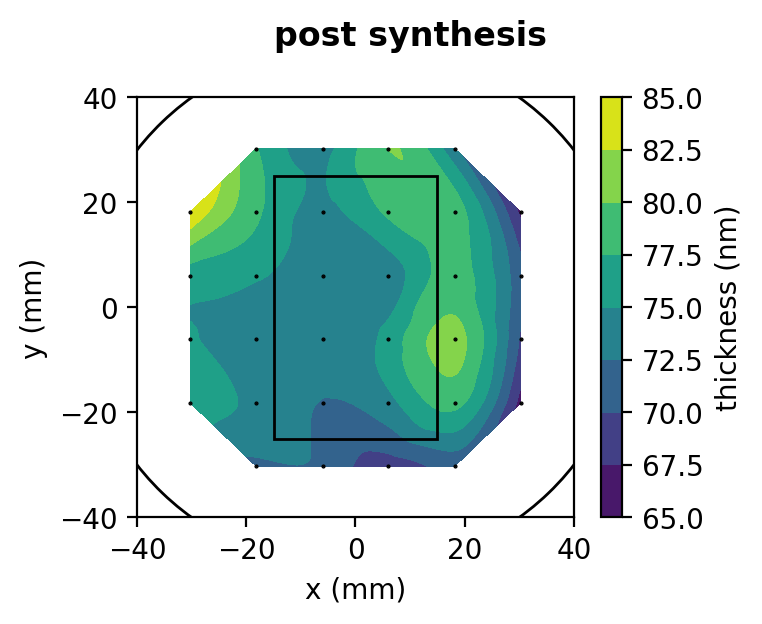

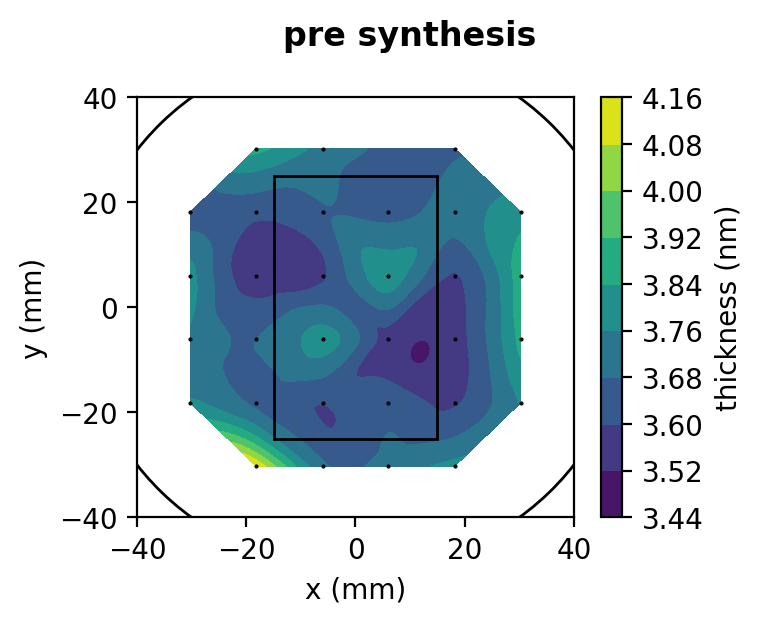

In [9]:
for name, df in outputs.items():
    fig, ax = plt.subplots(figsize=(3.9,3), dpi=200)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

    grid_x, grid_y = np.mgrid[-35:35:500j, -35:35:500j]

    interp_points =  np.array([grid_x, grid_y]).T
    points = np.array([df['X pos'], df['Y pos']]).T

    interpgrid = griddata(points=points, values=df['thickness'], xi=(grid_x, grid_y), method='cubic')
    
    cntr = ax.contourf(grid_x, grid_y, interpgrid)
    cbar = fig.colorbar(cntr, ax=ax)

    ax.scatter(df['X pos'], df['Y pos'], color='k', marker='.',s=1)

    radius=50
    circ = plt.Circle((0, 0), radius=radius, zorder=10, facecolor=[1,1,1,0], edgecolor='k')
    ax.add_artist(circ)

    rec = plt.Rectangle((-15, -25), width=30, height=50, zorder=10, facecolor=[1,1,1,0], edgecolor='k')
    ax.add_artist(rec)

    ax.set(ylabel='y (mm)', xlabel='x (mm)', ybound=(-40,40), xbound=(-40,40))
    cbar.set_label('thickness (nm)')
    fig.suptitle(name[:-4], fontweight='bold')